In [1]:
import os
n_cores = 5
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from online_cp import PluginMartingale
from scipy.optimize import brentq
from tqdm.notebook import tqdm
from online_cp import ConformalRidgeRegressor
from sklearn.datasets import fetch_california_housing
import h5py

def quantile(p, cdf_func):
# Invert CDF using root-finding (find x such that cdf(x) = p)
    return brentq(lambda x: cdf_func(x) - p, 0, 1)

rnd_gen = np.random.default_rng(2024)
from online_cp.evaluation import Evaluation

In [2]:
def load_wine_original():
    wine_quality = fetch_ucirepo(id=186) 

    wine = wine_quality.data.original

    X = wine.drop(columns=['quality', 'color']).values
    Y = wine['quality'].astype('float').values

    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    label_space = np.unique(Y)

    return X, Y, label_space

def load_wine_change_point():
    wine_quality = fetch_ucirepo(id=186) 

    reds = wine_quality.data.original[wine_quality.data.original.color == 'red']
    whites = wine_quality.data.original[wine_quality.data.original.color == 'white']

    # Shuffle the sets (uncomment if we run all data)
    reds = reds.sample(reds.shape[0], random_state=2024)
    whites = whites.sample(whites.shape[0], random_state=2024)

    change_point = whites.shape[0]

    X_red = reds.drop(columns=['quality', 'color']).values
    X_white = whites.drop(columns=['quality', 'color']).values
    y_red = reds['quality'].astype('float').values
    y_white = whites['quality'].astype('float').values

    X = np.concatenate([X_white, X_red])
    Y = np.concatenate([y_white, y_red])

    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    label_space = np.unique(Y)

    return X, Y, label_space

def load_usps():
    path = '../data/data_martingale_experiment/usps.h5'
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get('data')[:]
        y_train = train.get('target')[:]
        test = hf.get('test')
        X_test = test.get('data')[:]
        y_test = test.get('target')[:]

    X = np.concatenate([X_train, X_test])
    Y = np.concatenate([y_train, y_test])

    label_space = np.unique(Y)

    return X, Y, label_space

def load_satlog():
    # fetch dataset 
    statlog_landsat_satellite = fetch_ucirepo(id=146) 
    
    # data (as pandas dataframes) 
    X = statlog_landsat_satellite.data.features.values
    Y = statlog_landsat_satellite.data.targets.values.flatten()

    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    label_space = np.unique(Y)

    return X, Y, label_space

def load_dataset(name):
    if name == 'wine':
        return load_wine_original()
    elif name == 'usps':
        return load_usps()
    elif name == 'wine_change_point':
        return load_wine_change_point()
    elif name == 'satlog':
        return load_satlog()
    else:
        print(f'No dataset named {name}')

In [3]:
housing = fetch_california_housing()

N = 10000
data = housing.data
target = housing.target

# X, X_other, Y, Y_other = train_test_split(data, target, train_size=N, random_state=42)

X = data[:N]
C = 2
Y = target[:N] # Introduce a change point after half of the data
Y[N//2:] += C

# # Generate data
# X = rnd_gen.normal(loc=0, scale=1, size=(2000, 4))
# beta1 = np.array([2, 1, 0, 0])
# beta2 = np.array([0, -2,-1, 0])
# beta3 = np.array([0, 0, 2, 1])
# Y1 = X[:500] @ beta1 + rnd_gen.normal(loc=0, scale=1, size=500)
# Y2 = X[500:1500] @ beta2 + rnd_gen.normal(loc=0, scale=1, size=1000)
# Y3 = X[1500:] @ beta3 + rnd_gen.normal(loc=0, scale=1, size=500)
# Y = np.concatenate([Y1, Y2, Y3])

In [4]:
# dataset = 'usps'
# X, Y, label_space = load_dataset(dataset)

In [5]:
epsilon = 0.1

eps = epsilon
bounds = 'both'

cp = ConformalRidgeRegressor(a=0.1, studentised=True, warnings=False)

base_eval = Evaluation(['err', 'winkler', 'width'])
protected_eval = Evaluation(['err', 'winkler', 'width'])
aci_eval = Evaluation(['err', 'winkler', 'width'])

# Ensure that we can get informative prediction sets from the start
X_init_train = X[:int(np.ceil(2/epsilon))]
y_init_train = Y[:int(np.ceil(2/epsilon))]

X_process = X[int(np.ceil(2/epsilon)):]
y_process = Y[int(np.ceil(2/epsilon)):]

delta = 0.01
M = y_process.size
gamma_opt = (max(epsilon, 1-epsilon))/(delta*M - 1)
gamma = gamma_opt

cp.learn_initial_training_set(X_init_train, y_init_train)

martingale = PluginMartingale(warnings=False, min_sample_size=300)

p_values = np.empty_like(y_process)
protected_p_values = np.empty_like(y_process)
aci_p_values = np.empty_like(y_process)

# base_predictions = np.empty(shape=(y_process.shape[0], 2))
# protected_predictions = np.empty(shape=(y_process.shape[0], 2))
# aci_predictions = np.empty(shape=(y_process.shape[0], 2))

eps_array = np.empty_like(y_process)
epsilon_hat_array = np.empty_like(y_process)

Err = 0
err = 0


for i, (obj, lab) in tqdm(enumerate(zip(X_process, y_process)), total=y_process.size):

    # Base prediction
    Gamma, precomputed = cp.predict(obj, epsilon=epsilon, return_update=True, bounds=bounds)
    # base_predictions[i, :] = Gamma

    # Protected prediction
    # Protected significance level
    func = lambda x: martingale.B_n(x) - epsilon
    epsilon_hat = brentq(func, 0, 1)

    protected_Gamma = cp.predict(obj, epsilon=epsilon_hat, bounds=bounds)
    # protected_predictions[i, :] = protected_Gamma
    epsilon_hat_array[i] = epsilon_hat

    aci_Gamma = cp.predict(obj, epsilon=eps)
    # aci_predictions[i, :] = aci_Gamma
    eps_array[i] = eps

    # Compute p-values
    p = cp.compute_p_value(x=obj, y=lab, precomputed=precomputed, bounds=bounds, smoothed=False)
    protected_p = martingale.B_n(p)
    aci_inv = lambda x: (x - eps + gamma*err) / gamma
    aci_p = aci_inv(p)

    martingale.update_martingale_value(p)

    p_values[i] = p
    protected_p_values[i] = protected_p
    aci_p_values[i] = aci_p

    # ACI update
    err = cp.err(aci_Gamma, lab)
    Err += err
    eps += gamma*(epsilon - err)

    cp.learn_one(obj, lab)

    base_eval.update(y=lab, Gamma=Gamma, epsilon=epsilon)
    protected_eval.update(y=lab, Gamma=protected_Gamma, epsilon=epsilon)
    aci_eval.update(y=lab, Gamma=aci_Gamma, epsilon=epsilon)

  0%|          | 0/9980 [00:00<?, ?it/s]

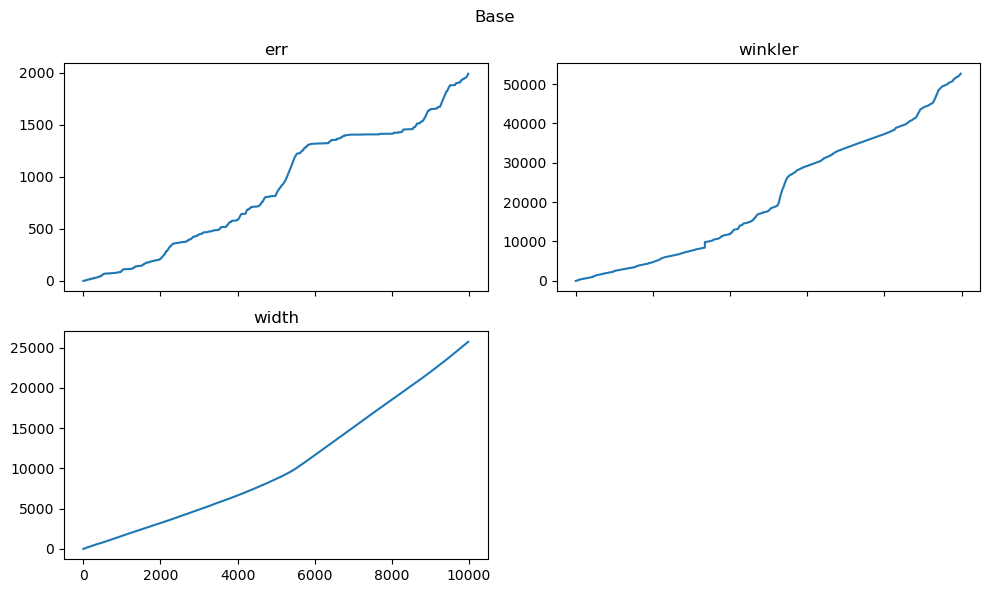

In [6]:
base_eval.plot_cumulative_results(title='Base')

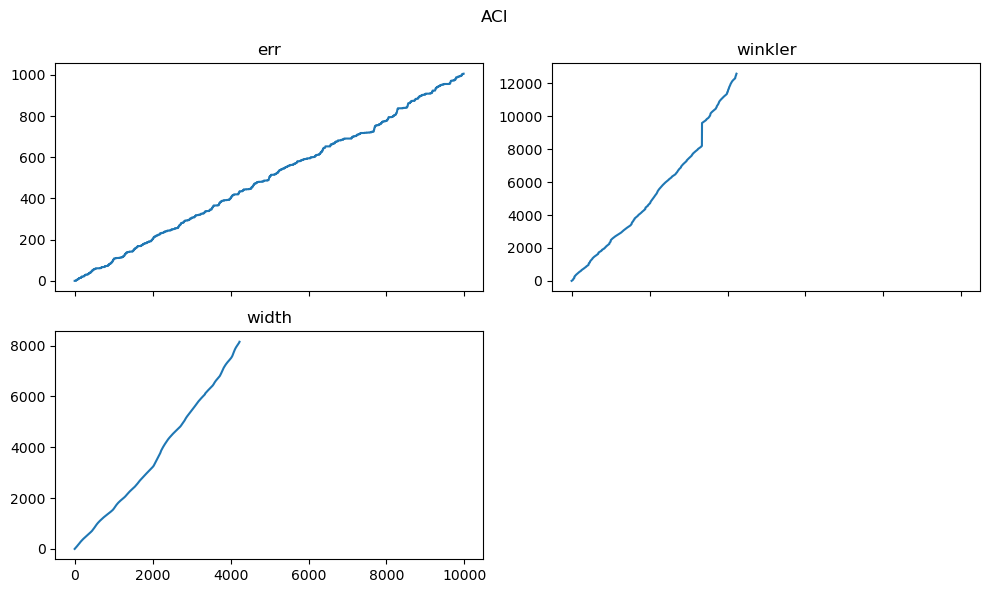

In [7]:
aci_eval.plot_cumulative_results(title='ACI')

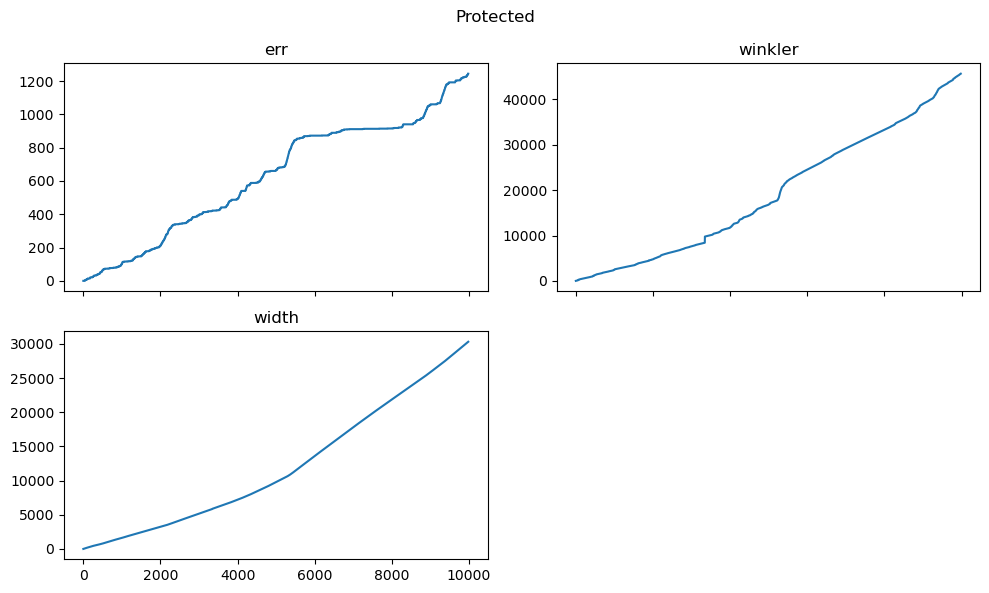

In [8]:
protected_eval.plot_cumulative_results(title='Protected')

Text(0.5, 1.0, 'Approximate calibration plot CRR')

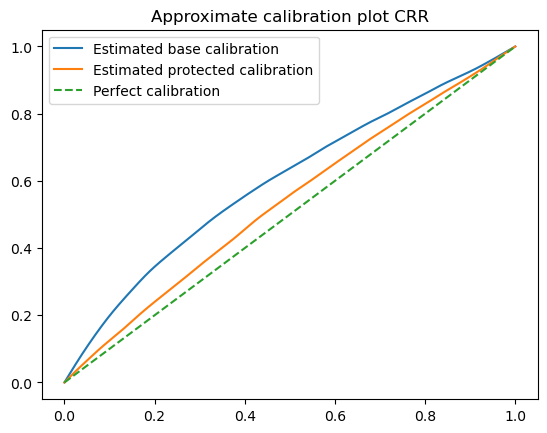

In [9]:
calibration_martingale = PluginMartingale(warnings=False) 
for p in protected_p_values:
    calibration_martingale.update_martingale_value(p)

plt.plot(
    np.linspace(0, 1, 1000),
    martingale.B_n(np.linspace(0, 1, 1000)),
    label='Estimated base calibration'
)
plt.plot(
    np.linspace(0, 1, 1000),
    calibration_martingale.B_n(np.linspace(0, 1, 1000)),
    label='Estimated protected calibration'
)
plt.plot(
    np.linspace(0, 1, 1000),
    np.linspace(0, 1, 1000),
    linestyle='--',
    label='Perfect calibration'
)
plt.legend()
plt.title('Approximate calibration plot CRR')

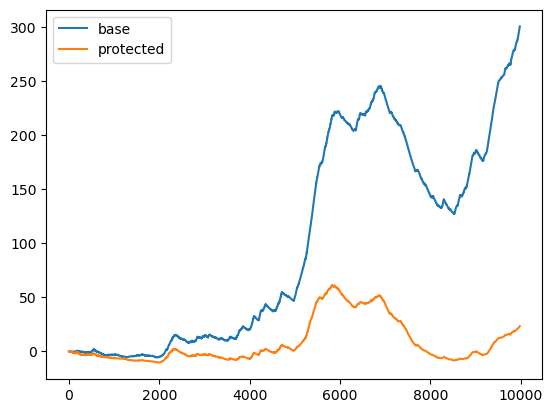

In [10]:
plt.plot(martingale.log10_martingale_values, label='base')
plt.plot(calibration_martingale.log10_martingale_values, label='protected')
plt.legend()

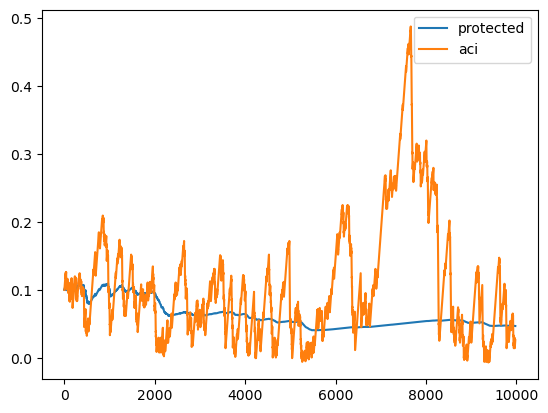

In [11]:
plt.plot(epsilon_hat_array, label='protected')
plt.plot(eps_array, label='aci')
plt.legend()

In [12]:
base_eval.winkler.mean(), protected_eval.winkler.mean(), aci_eval.winkler.mean()

(5.273127693952641, 4.578144843467137, inf)

In [13]:
base_eval.width.mean(), protected_eval.width.mean(), aci_eval.width.mean()

(2.5769940945851197, 3.0382097699578194, inf)

In [14]:
base_eval.err.mean(), protected_eval.err.mean(), aci_eval.err.mean()

(0.199498997995992, 0.12464929859719438, 0.10080160320641282)

In [15]:
base_eval.summarize()['winkler']

{'mean': 5.273127693952662,
 'std': 15.986377009263618,
 'min': 1.3374214970507432,
 'max': 1394.686195411251,
 'last': 14.470138469043675}

In [16]:
protected_eval.summarize()['winkler']

{'mean': 4.578144843467138,
 'std': 14.666620233601565,
 'min': 1.3053599392466204,
 'max': 1354.8991015050262,
 'last': 4.768626746657346}

In [17]:
aci_eval.summarize()['winkler']

/home/johan/miniconda3/envs/onlineCP/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


{'mean': inf,
 'std': nan,
 'min': 1.1240582543292126,
 'max': inf,
 'last': 5.2851967835753015}